In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
X1 = torch.rand(10000,1) # 输入特征1
X2 = torch.rand(10000,1) # 输入特征2
X3 = torch.rand(10000,1) # 输入特征3
X1.shape,X2.shape,X3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [6]:
Y1 = ( (X1+X2+X3)<1 ).float() # 输出特征1
Y2 = ( (1<(X1+X2+X3)) & ((X1+X2+X3)<2) ).float() # 输出特征2
Y3 = ( (X1+X2+X3)>2 ).float() # 输出特征3
Data = torch.cat([X1,X2,X3,Y1,Y2,Y3],axis=1) # 整合数据集
Data = Data.to('cuda:0') # 把数据集搬到GPU 上
Data

tensor([[0.1741, 0.3299, 0.4254, 1.0000, 0.0000, 0.0000],
        [0.5860, 0.8195, 0.9593, 0.0000, 0.0000, 1.0000],
        [0.0920, 0.3530, 0.4592, 1.0000, 0.0000, 0.0000],
        ...,
        [0.7832, 0.4085, 0.1544, 0.0000, 1.0000, 0.0000],
        [0.9865, 0.1661, 0.0364, 0.0000, 1.0000, 0.0000],
        [0.4696, 0.3969, 0.0038, 1.0000, 0.0000, 0.0000]], device='cuda:0')

In [7]:
# 划分训练集与测试集
train_size = int(len(Data) * 0.7) # 训练集的样本数量
test_size = len(Data) - train_size # 测试集的样本数量
Data = Data[torch.randperm( Data.size(0)) , : ] # 打乱样本的顺序
train_Data = Data[ : train_size , : ] # 训练集样本
test_Data = Data[ train_size : , : ] # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

In [8]:
class DNN(nn.Module):
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential( # 按顺序搭建各层
            nn.Linear(3, 5), nn.ReLU(), # 第1 层：全连接层
            nn.Linear(5, 5), nn.ReLU(), # 第2 层：全连接层
            nn.Linear(5, 5), nn.ReLU(), # 第3 层：全连接层
            nn.Linear(5, 3) # 第4 层：全连接层
        )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [10]:
model = DNN().to('cuda:0')
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [11]:
# 查看神经网络的内部参数（权重与偏置）
for name,param in model.named_parameters():
    print(f"参数:{name}\n形状:{param.shape}\n数值:{param}")


参数:net.0.weight
形状:torch.Size([5, 3])
数值:Parameter containing:
tensor([[ 0.2285,  0.2209, -0.2614],
        [-0.1105, -0.3926, -0.0098],
        [-0.2108,  0.4920,  0.3990],
        [-0.5470, -0.3488,  0.2166],
        [-0.2031, -0.5005, -0.1184]], device='cuda:0', requires_grad=True)
参数:net.0.bias
形状:torch.Size([5])
数值:Parameter containing:
tensor([-0.5513,  0.2977,  0.3784,  0.0811,  0.1474], device='cuda:0',
       requires_grad=True)
参数:net.2.weight
形状:torch.Size([5, 5])
数值:Parameter containing:
tensor([[ 0.0562,  0.0951, -0.1479,  0.0361, -0.3199],
        [-0.2792,  0.0240,  0.0068,  0.0809,  0.1707],
        [-0.1342, -0.1620, -0.2055,  0.2806,  0.3577],
        [-0.3058,  0.0094,  0.1128, -0.4231, -0.1016],
        [ 0.2568, -0.1845,  0.2163,  0.3135,  0.0800]], device='cuda:0',
       requires_grad=True)
参数:net.2.bias
形状:torch.Size([5])
数值:Parameter containing:
tensor([ 0.3016, -0.3720,  0.0629,  0.2672,  0.2124], device='cuda:0',
       requires_grad=True)
参数:net.4.weight
形状:

In [13]:
# 损失函数的选择
loss_fn = nn.MSELoss()

In [14]:
# 优化算法的选择
learning_rate = 0.01 # 设置学习率
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

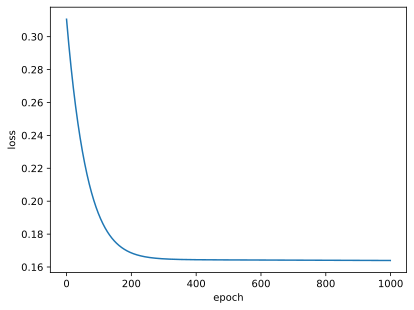

In [16]:
# 训练网络
epochs = 1000
losses = [] # 记录损失函数变化的列表
# 给训练集划分输入与输出
X = train_Data[ : , :3 ] # 前3 列为输入特征
Y = train_Data[ : , -3: ] # 后3 列为输出特征
for epoch in range(epochs):
    Pred = model(X) # 一次前向传播（批量）
    loss = loss_fn(Pred, Y) # 计算损失函数
    losses.append(loss.item()) # 记录损失函数的变化
    optimizer.zero_grad() # 清理上一轮滞留的梯度
    loss.backward() # 一次反向传播
    optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss'), plt.xlabel('epoch')
plt.show()

In [17]:
# 测试网络
# 给测试集划分输入与输出
X = test_Data[:, :3] # 前3 列为输入特征
Y = test_Data[:, -3:] # 后3 列为输出特征
with torch.no_grad(): # 该局部关闭梯度计算功能
    Pred = model(X) # 一次前向传播（批量）
    Pred[:,torch.argmax(Pred, axis=1)] = 1
    Pred[Pred!=1] = 0
    correct = torch.sum( (Pred == Y).all(1) ) # 预测正确的样本
    total = Y.size(0) # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 66.86666870117188 %


In [18]:
# 保存网络
torch.save(model,'model.pth')

In [19]:
# 导入网络
new_model =torch.load('model.pth')

In [20]:
# 给测试集划分输入与输出
X = test_Data[:, :3] # 前3 列为输入特征
Y = test_Data[:, -3:] # 后3 列为输出特征
with torch.no_grad(): # 该局部关闭梯度计算功能
    Pred = new_model(X) # 用新模型进行一次前向传播
    Pred[:,torch.argmax(Pred, axis=1)] = 1
    Pred[Pred!=1] = 0
    correct = torch.sum( (Pred == Y).all(1) ) # 预测正确的样本
    total = Y.size(0) # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 66.86666870117188 %
